# Training of a Serial Quantum Fourier model (Qiskit with SciPy)
Tested with: qiskit 1.4.4 and scipy 1.16.1 - Success

In [1]:
%%html
<style>
tr:nth-child(odd), tr:nth-child(even) {
  background-color: rgb(255, 255, 255);
}
th:nth-child(even),th:nth-child(odd),td:nth-child(even),td:nth-child(odd) {
  background-color: rgb(255, 255, 255);
}
table {float:left}
</style>

# Guest Lecture and Lab:<br>Simple QML models in Qiskit
<table>
    <tr><td style="vertical-align: top;"><strong>Aim</strong></td>
        <td>To implement a simple <strong>Qiskit</strong> quantum model using SciPy.<br>
            Note that in this example, we do not partition data, so only training performance is shown.</td></tr>
    <tr><td style="vertical-align: top;"><strong>Author</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em>, Australia</td></tr>
    <tr><td style="vertical-align: top;"><strong>Release</strong></td>
        <td>August 2025</td></tr>
    <tr><td style="vertical-align: top;"><strong>Datasets</strong></td>
        <td>The following data sets have been included in your exercises.<br>
            <table style="float: left;">
                <tr><td><em><strong>sinful_n100:</strong></em></td><td>$y = sin(0.7 x+0.5\pi)$</td></tr>
            </table>
        </td></tr>
</table>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/qiskit2-gpu/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit2-gpu/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit2-gpu/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit2-gpu/lib/python3.11/site-packages',
 '.',
 '..']

In [3]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector, Parameter

from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Utils

In [5]:
##### Data scaler
def scale_values(x, new_min=0, new_max=1):
    scaler = MinMaxScaler(feature_range=(new_min, new_max))
    return scaler.fit_transform(x.reshape(-1, 1)).flatten()

## Prepare raw TS data

In [6]:
##### Data settings
samples_no = 50

In [7]:
##### Data Generation
DATA_NAME=f'sinful_n{samples_no}'
X_raw = np.linspace(-2 * np.pi, 4 * np.pi, samples_no)
y_raw = np.sin(0.7 * X_raw + 0.5 * np.pi)

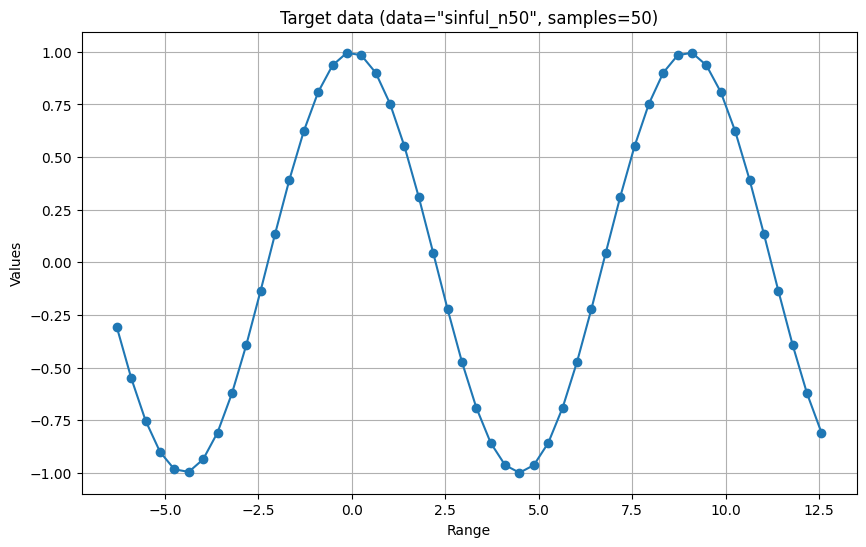

In [8]:
### Plot the curve vs original data
plt.figure(figsize=(10, 6))
plt.plot(X_raw, y_raw, linestyle='-', marker='o')
plt.title(f'Target data (data="{DATA_NAME}", samples={samples_no})')
plt.xlabel('Range')
plt.ylabel('Values')
plt.grid(True)
plt.show()

## Prepare data for encoding, training and testing

In [9]:
##### Settings

### Data partition settings
samples_test_pc = 0.3

### Data encoding setting
x_from = -1*np.pi
x_to =    1*np.pi
y_margin = 0.1
y_low = -1+y_margin
y_high = 1-y_margin

### Calculated values
samples_test_no = int(samples_no * samples_test_pc)
samples_train_no = samples_no - samples_test_no
(samples_train_no, samples_test_no)

(35, 15)

In [10]:
##### Prepare data for encoding
X = X_raw
y = scale_values(y_raw, new_min=y_low, new_max=y_high)
X = scale_values(X_raw, new_min=x_from, new_max=x_to)
(X.shape, y.shape)

((50,), (50,))

## Create a simple model to fit data

In [11]:
##### Create the circuit
def create_model(qubits_no=1, layers_no=1, add_meas=False):
    qr = QuantumRegister(qubits_no, 'q')
    ansatz = QuantumCircuit(qr, name="ansatz")
    param_x = Parameter('X')

    for q in range(qubits_no):
        ansatz.rx(param_x, q)
    
    for l in range(layers_no):
        ansatz.barrier()
        for q in range(qubits_no):
            ansatz.rx(Parameter(f'P{l:02d}_A{q:02d}'), q)
            ansatz.ry(Parameter(f'P{l:02d}_B{q:02d}'), q)
            ansatz.rz(Parameter(f'P{l:02d}_C{q:02d}'), q)
        for q in range(qubits_no-1):
            ansatz.cx(q, q+1)
        if qubits_no > 1:
            ansatz.cx(qubits_no-1, 0)
    if add_meas:
        ansatz.measure_all()
    return ansatz

In [12]:
### Assigns a model with weight and input values
def assign_model(model, weight_params, input_vals):
    global inputs_no
    x_param = model.parameters[-inputs_no]
    all_param_vals = np.concatenate((weight_params, input_vals))
    assigned_model = model.assign_parameters(all_param_vals)
    return assigned_model

## Prepare model training

In [13]:
##### Model settings for the model above

inputs_no = 1
qubits_no = 4
layers_no = 4
epochs = 30

In [14]:
##### The cost function
cost_vals = []     # To store cost values
params_vals = []   # To store parameter values

def create_objfun(model, estimator, epochs, print_iter=40):
    
    global cost_vals, params_vals
    cost_vals = []
    params_vals = []
    elapsed = 0
    start_time = time.time()
    multiplier = 40
    
    def objective_function(w_params_values, X, y):
        nonlocal model, estimator, epochs, print_iter, start_time, elapsed, multiplier
        global cost_vals, params_vals

        ### Accumulate losses
        total_loss = 0
        iters = len(cost_vals)
        
        for i in range(len(X)):
            x_val = X[i]
            y_val = y[i]
            
            # Assign parameters to the circuit (weights+inputs)
            # all_param_vals = np.append(w_params_values, x_val)
            # assigned_circuit = model.assign_parameters(all_param_vals)
            assigned_circuit = assign_model(model, w_params_values, [x_val])
            
            # Run the forward pass - get expvals
            result = estimator.run([(assigned_circuit, observable)]).result()[0]
            expectation_value = result.data.evs
    
            # Calculate loss
            loss = (expectation_value - y_val)**2
            total_loss += loss
    
        ### Calculate cost
        cost = total_loss / len(X)
        cost_vals.append(cost)
        params_vals.append(w_params_values)

        ### Print stats
        elapsed = time.time() - start_time
        time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed))
        if (print_iter == 0) or (iters % print_iter == 0):
            print(f"({time_str}) - Iter#: {iters:3d}, Cost: {cost:.6f}")
        return cost
        
    return objective_function

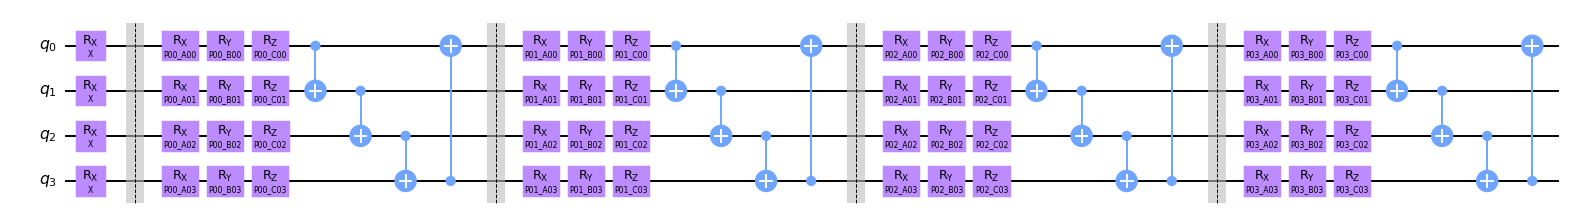

In [15]:
### Create the single, reusable circuit template
model = create_model(qubits_no=qubits_no, layers_no=layers_no)
w_params = model.parameters[:-inputs_no]
x_param = model.parameters[-inputs_no]
num_params = len(w_params)
model.draw(output='mpl', style='clifford', scale=0.7, fold=True)

## Model training

In [16]:
##### Run

### Training loop initialisation
cost_vals = []
params_vals = []
initial_params = np.random.rand(num_params) * 2 * np.pi

### Define the observable and estimator
observable = SparsePauliOp.from_list([("Z" * qubits_no, 1)]) 
estimator = StatevectorEstimator()
costfun = create_objfun(model, estimator, epochs, print_iter=100)

### Start timer
start = time.time()

### The Training Loop
print("\nStarting optimization with SciPy...\n")
result = minimize(
    fun=costfun,
    x0=initial_params,
    args=(X, y,),
    method='L-BFGS-B',
    options={'maxiter': epochs}
)

### End training
elapsed = time.time() - start
time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed))

final_params = result.x
final_loss = result.fun

print("\nOptimization complete.\n")
print(f"Final loss: {final_loss:.6f}, total time: {time_str}\n")


Starting optimization with SciPy...

(00:00:00) - Iter#:   0, Cost: 0.507932
(00:00:13) - Iter#: 100, Cost: 0.116353
(00:00:25) - Iter#: 200, Cost: 0.039946
(00:00:38) - Iter#: 300, Cost: 0.022890
(00:00:51) - Iter#: 400, Cost: 0.017903
(00:01:04) - Iter#: 500, Cost: 0.011144
(00:01:17) - Iter#: 600, Cost: 0.006592
(00:01:30) - Iter#: 700, Cost: 0.005088
(00:01:43) - Iter#: 800, Cost: 0.004607
(00:01:56) - Iter#: 900, Cost: 0.004490
(00:02:09) - Iter#: 1000, Cost: 0.004252
(00:02:22) - Iter#: 1100, Cost: 0.004193
(00:02:35) - Iter#: 1200, Cost: 0.004174
(00:02:48) - Iter#: 1300, Cost: 0.004142
(00:03:01) - Iter#: 1400, Cost: 0.004125
(00:03:14) - Iter#: 1500, Cost: 0.004102

Optimization complete.

Final loss: 0.004102, total time: 00:03:16



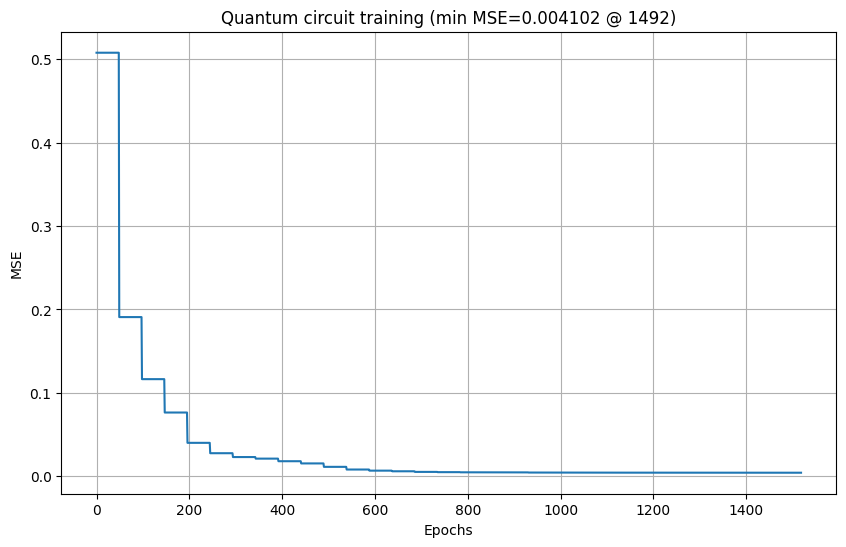

In [17]:
### Plot the cost history
opt_cost = min(cost_vals)
x_of_opt = np.argmin(cost_vals)

plt.figure(figsize=(10, 6))
plt.plot(cost_vals, '-', label='Cost')
plt.title(f'Quantum circuit training (min MSE={opt_cost:.6f} @ {x_of_opt})')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

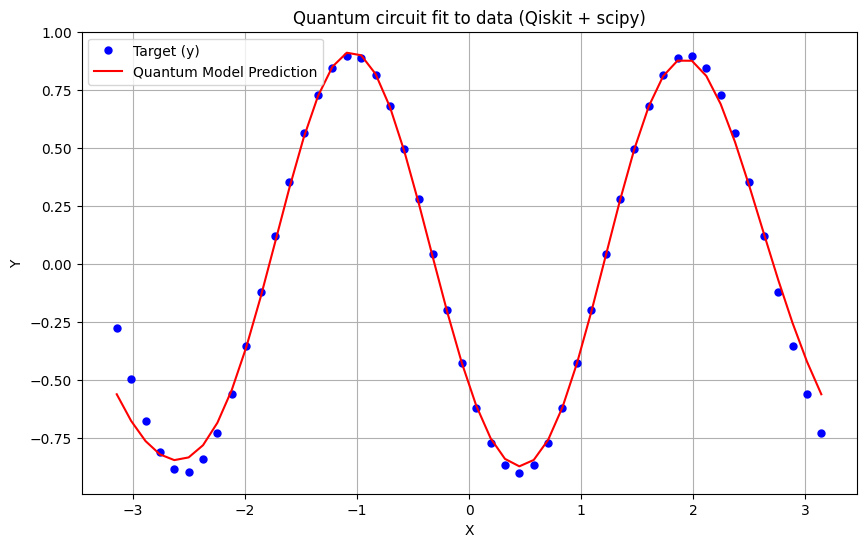

In [18]:
### Calculate the fitting curve
predictions = []
for x_val in X:
    x_param = model.parameters[-inputs_no]
    all_param_vals = np.append(final_params, x_val)
    # assigned_circuit = model.assign_parameters(all_param_vals)
    assigned_circuit = assign_model(model, final_params, [x_val])
    expectation_value = estimator.run([(assigned_circuit, observable)]).result()[0].data.evs
    predictions.append(expectation_value)
    
### Plot the curve vs original data
plt.figure(figsize=(10, 6))
plt.plot(X, y, '.', color='blue', markersize=10, label='Target (y)')
plt.plot(X, predictions, linestyle='-', color='red', label='Quantum Model Prediction')
plt.title('Quantum circuit fit to data (Qiskit + scipy)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

## System (Linux)

In [19]:
import sys
print(f'\nEnvironment:\n\n{sys.prefix}\n')


Environment:

/home/jacob/miniconda3/envs/qiskit2-gpu



In [20]:
import os
print(f"\nSignificant packages:\n")
os.system('pip list | grep -e qiskit -e scipy');


Significant packages:

qiskit                    1.4.4
qiskit-aer-gpu            0.15.1
qiskit-ibm-runtime        0.41.0
qiskit-machine-learning   0.8.3
scipy                     1.16.1
